In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [5]:
sm.links.shape

(158297, 13)

### Prepare links for pathfinder

In [6]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type']
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [7]:
# Generate headways (two times the waiting time at a stop when changing between trips)
# ASSUMPTION: Take average headways for core hours between 6 a.m. and 8 p.m.
hours = set(range(6, 20))
def n_trips(g):
    hour_list = list(g)[0]
    return sum([hour_list.count(h) for h in set(hour_list).intersection(hours)])
freq = aux.frequencies.groupby(['stop_id', 'route_id']).agg({'hour': n_trips})
freq['hour'] = 14*3600 / freq['hour'] # 14 hours

In [8]:
headway_dict = freq['hour'].to_dict()
sm.links['headway'] = [headway_dict[(node, ind)]
                       if (node, ind) in headway_dict.keys() else np.nan
                       for ind, node in sm.links.set_index('route_id')['a'].items()]

array([<AxesSubplot:ylabel='a'>], dtype=object)

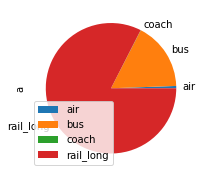

In [9]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg(
    {'a': 'count'}).plot.pie(subplots=True, figsize=(3,3))

In [10]:
len(sm.links.loc[sm.links['headway'].isna()])

11981

In [11]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [12]:
# ASSUMPTION: Air trips require security checks and so on...
sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2

In [13]:
# ASSUMPTION: Long-distance rail and coach trips are timed well
# and have maximum waiting times of 20 minutes
sm.links.loc[sm.links['route_type'].isin(['rail_long', 'coach']), 'headway'] = \
    sm.links.loc[sm.links['route_type'].isin(['rail_long', 'coach']),
                 'headway'].clip(lower=5*60*2, upper=20*60*2)

In [14]:
# ASSUMPTION: Maximum waiting time is 60 minutes, minumum is 3 minutes
sm.links['headway'] = sm.links['headway'].clip(lower=3*60*2, upper=60*60*2)

In [15]:
sm.links['headway'] = sm.links['headway'].astype(int)

<AxesSubplot:>

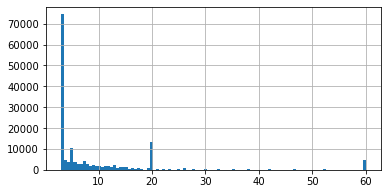

In [16]:
# Waiting time distribution in minutes
(sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
sm.links['headway'].mean()/60/2

9.150743591687355

In [18]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = {'bus': 0,
             'rail_short': 20,
             'rail_long': 30,
             'coach': 60,
             'air': 60}
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict)*60 # in s

In [19]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    tqdm.pandas()
    sm.links['length'] = sm.links['geometry'].progress_apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [20]:
# Correct lengths, if not done in prep22
s = sm.links.sample(10)
if list(s['length']) == list(s['geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))):
    len_factors = {'rail_short': 1.15,
                   'rail_long': 1.1,
                   'bus': 1.1459025616315412,
                   'coach': 1.0878094787397228}
    for mode, factor in len_factors.items():
        sm.links.loc[sm.links['route_type']==mode, 'length'] *= factor
    sm.links['length'] = sm.links['length'].astype(int)
    print('Corrected lengths')

In [21]:
sm.links.sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,route_type_disagg,boarding_time
index,,,,,,,,,,,,,
r_s_65409,DE239_r_s_0,DE238_r_s_0,rail_short,"LINESTRING (12.15781 49.35271, 12.09182 48.99953)",4,rail_short_297,924,rail_short_12179,45000,360,10.485,rail_short,1200


### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [22]:
'''This cell would run all possible mode combinations
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''

"This cell would run all possible mode combinations\nsm.step_pt_pathfinder(\n    broken_routes=False,\n    broken_modes=True, # Allow different mode combinations\n    route_column='route_id',\n    mode_column='route_type',\n    boarding_time=0, # Assumption\n    alighting_time=0,\n    speedup=True,\n    walk_on_road=False,\n    keep_pathfinder=False, # Saves it as attribute for multiple iterations\n    force=False, # If indices are inconsistent\n    path_analysis=True, # Create path, time and length columns\n    drop_duplicates=True, # Considering duplicate paths\n    cutoff=np.inf, # distance limit between points for Dijkstra algorithm\n    od_set=od_set) # Exclude OD pairs that are not used"

In [23]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [24]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long' in x or
                          'rail_short' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [25]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [26]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|██████████████████████████████████████████████████████████| 18/18 [18:24<00:00, 61.39s/it]


In [27]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
39123,DE249,DE943,16794.5,"[DE249, DE249_r_s_0, r_s_4419, DED44_r_s_0, DE...",False,mode_breaker,{air}


In [28]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|██████████████████████████████████████████████████████| 2785052/2785052 [01:45<00:00, 26375.02it/s]


In [29]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

2785052


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
83531,DE925,DE26A,10759.0,"[DE925, DE925_bus_0, bus_744146, DE926_bus_0, ...",False,mode_breaker,{rail_long},"[DE925_bus_0, DE926_bus_0, DEA44_bus_0, DE734_...","[DE926_bus_0, DEA44_bus_0, DE734_bus_0, DE737_...","[DE925_bus_0, DE926_bus_0, DEA44_bus_0, DE734_...","[bus_744146, bus_1692298, bus_554422, bus_2209...","[(DE26A_bus_0, DE26A_r_s_0)]","[(DE925, DE925_bus_0), (DE26A_r_s_0, DE26A)]","[DE926_bus_0, DEA44_bus_0, DE734_bus_0, DE737_...","[bus_744146, bus_1692298, bus_554422, bus_2209...","[bus_744146, bus_1692298, bus_554422, bus_2209...",False,6,4597,398495
48104,DE266,DEG09,11061.5,"[DE266, DE266_r_s_0, r_s_84963, DEG0B_r_s_0, r...",False,mode_breaker,"{air, bus, rail_long}","[DE266_r_s_0, DEG0B_r_s_0, DEG0C_r_s_3]","[DEG0B_r_s_0, DEG0C_r_s_3, DEG09_r_s_0]","[DE266_r_s_0, DEG0B_r_s_0, DEG0C_r_s_3, DEG09_...","[r_s_84963, r_s_132312, r_s_132320, r_s_94248,...",[],"[(DE266, DE266_r_s_0), (DEG09_r_s_0, DEG09)]","[DEG0B_r_s_0, DEG0C_r_s_3]","[r_s_84963, r_s_132312, r_s_94248]","[r_s_84963, r_s_132320, r_s_94249]",False,2,4023,180365
54847,DE27B,DEB32,10956.0,"[DE27B, DE27B_bus_0, bus_697323, DE27C_bus_0, ...",False,mode_breaker,"{air, rail_short}","[DE27B_bus_0, DE27C_bus_0, DE274_bus_0, DE146_...","[DE27C_bus_0, DE274_bus_0, DE146_bus_0, DE145_...","[DE27B_bus_0, DE27C_bus_0, DE274_bus_0, DE146_...","[bus_697323, bus_1730806, bus_1647457, bus_112...",[],"[(DE27B, DE27B_bus_0), (DEB32_bus_0, DEB32)]","[DE27C_bus_0, DE274_bus_0, DE146_bus_0, DE145_...","[bus_697323, bus_1730806, bus_1647457, bus_112...","[bus_697323, bus_1730806, bus_1647457, bus_112...",False,12,5680,699876


### Add attributes to LoS table

In [30]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [31]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')


In [32]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
129488,22,919823,18659.5,1029,0,13069,4561.5,0,18659.5
2928,1,160717,8991.0,2739,0,3492,360.0,0,6591.0


In [33]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [34]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [35]:
# Add number of transfers
#sm.pt_los['ntransfers'] = sm.pt_los['boardings'].apply(lambda l: max(0, len(l) - 1))

In [36]:
# Add price, parametrisation comes later because
# our GTFS feeds come without fares
sm.pt_los['price'] = 0

In [37]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type,price
102575,DEA1F,DEB3B,11390.0,"[DEA1F, DEA1F_bus_0, bus_2160062, DEA12_bus_1,...",False,mode_breaker,{coach},"[DEA1F_bus_0, DEA12_bus_1, DEA14_bus_0, DEA1D_...","[DEA12_bus_1, DEA14_bus_0, DEA1D_bus_0, DEA27_...","[DEA1F_bus_0, DEA12_bus_1, DEA14_bus_0, DEA1D_...",...,381852,1308,0,7335,2747.0,0,11390.0,{bus},bus,0


In [38]:
# Make a safety copy before restricting results
los = sm.pt_los.copy()

In [39]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [40]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(1476688, 30)

In [41]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.06it/s]


In [42]:
# Berlin - Stuttgart
all_pt_paths(sm, 'DE300', 'DE111', verbose=False, group_name='route_type')

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.87it/s]


In [43]:
# Look at Berlin - Stuttgart times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE111')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
44646,0,845147,{coach},"[coach_16396, coach_16397, coach_16398, coach_...",28255.0,2876,97,21382,300.0,0,24655.0
183510,0,866911,{rail_short},"[r_s_151329, r_s_151330, r_s_151331, r_s_15133...",26988.0,2328,0,21360,2100.0,0,25788.0
334262,0,868429,{rail_long},"[r_l_6123, r_l_6124, r_l_6125, r_l_6126, r_l_6...",24428.0,2870,18,18540,1200.0,0,22628.0
466048,2,715022,"{rail_long, rail_short}","[r_l_5756, r_l_5757, r_l_5758, r_s_119880, r_s...",22859.5,2829,994,12990,1846.5,0,18659.5
598186,19,1573994,{bus},"[bus_2547437, bus_732495, bus_568191, bus_3008...",13540.0,1488,0,8125,3927.0,0,13540.0
736027,19,1573994,{bus},"[bus_2547437, bus_732495, bus_732819, bus_3008...",13540.0,1488,0,8125,3927.0,0,13540.0
822438,19,1573994,{bus},"[bus_2547437, bus_732495, bus_568191, bus_3008...",13540.0,1488,0,8125,3927.0,0,13540.0
891163,19,1573994,{bus},"[bus_2547437, bus_732495, bus_732819, bus_3008...",13540.0,1488,0,8125,3927.0,0,13540.0
972313,1,637052,"{air, rail_short}","[air_61, r_s_153790, r_s_153794]",19748.0,2050,3988,6030,2880.0,0,14948.0
1060280,0,617034,{air},[air_61],19806.0,3690,743,4800,2700.0,0,11933.0


In [44]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x or 'air' in x))]
sm.pt_los.shape

(1379230, 30)

In [45]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(1379230, 30)

In [46]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(1368370, 30)

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

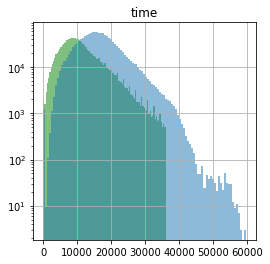

In [47]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
               ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                 bins=100, figsize=(4,4), log=True, alpha=.5))

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

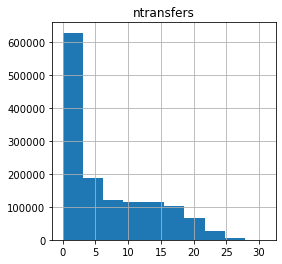

In [48]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

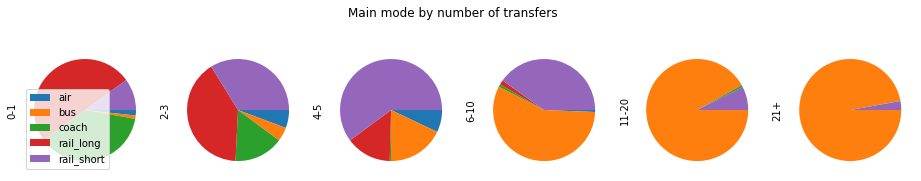

In [49]:
# Main mode distribution by transfers
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

<AxesSubplot:xlabel='route_types'>

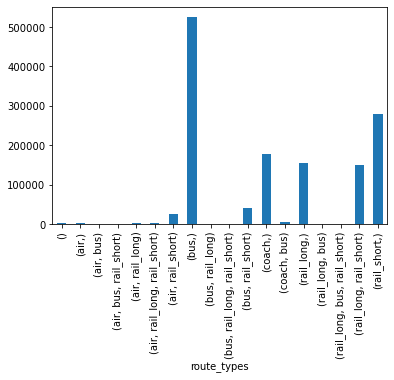

In [50]:
# Distribution of mode combinations
t['route_types'] = t['route_types'].apply(tuple)
t.groupby('route_types').count()['route_type'].plot(kind='bar')

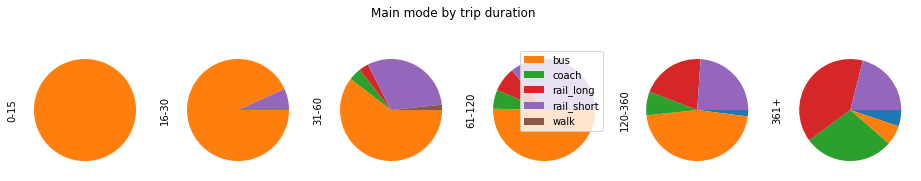

In [51]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[3].legend()

In [52]:
t = None

In [53]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=7]
    print(sm.pt_los.shape)
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('coach')])>2)
                                ))]
    print(sm.pt_los.shape)

(857966, 30)
(814279, 30)


In [54]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth([0]).reset_index()
sm.pt_los.shape

(476110, 30)

In [55]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') & (sm.pt_los['length']>100000))]
sm.pt_los.shape

(434403, 30)

<AxesSubplot:xlabel='route_types'>

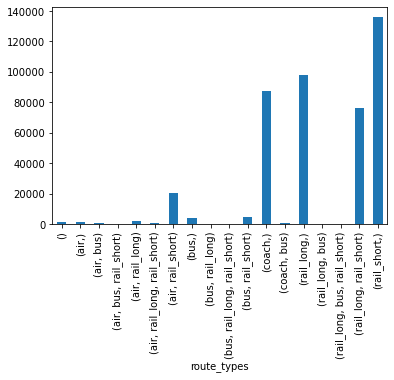

In [56]:
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

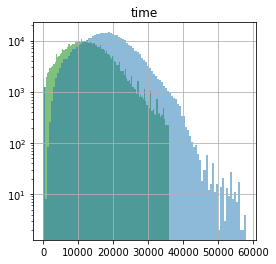

In [57]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
               ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                 bins=100, figsize=(4,4), log=True, alpha=.5))

In [58]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.20it/s]


In [59]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
167283,0,412182,"(coach,)",[coach_19079],18991.0,1893,298,12000,1200.0,0,15391.0
167284,0,427954,"(rail_long,)","[r_l_7252, r_l_7253]",11918.0,2796,62,6060,1200.0,0,10118.0
167285,1,479932,"(rail_short,)","[r_s_128790, r_s_128791, r_s_128795, r_s_12879...",15772.5,3582,0,8968,822.5,0,13372.5


In [60]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price
1354,DE112,DE111,"(bus,)",2758.0,"(DE112, DE112_bus_3, bus_1969986, DE113_bus_4,...",False,mode_breaker,"{air, rail_long, rail_short}","[DE112_bus_3, DE113_bus_4]","[DE113_bus_4, DE111_bus_1]",...,26932,26932,1724,0,674,360.0,0,2758.0,bus,0
1355,DE112,DE111,"(coach,)",11019.0,"(DE112, coach_n_FLIXBUS:4278, coach_1875, coac...",False,mode_breaker,"{air, bus, rail_long, rail_short}",[coach_n_FLIXBUS:4278],[coach_n_FLIXBUS:8058],...,29863,29863,2539,1430,2400,1050.0,0,7419.0,coach,0
1356,DE112,DE111,"(rail_long,)",6278.0,"(DE112, r_l_n_601, r_l_6086, r_l_n_742, DE111)",False,mode_breaker,"{air, bus, rail_short}",[r_l_n_601],[r_l_n_742],...,24536,24536,2078,0,1200,1200.0,0,4478.0,rail_long,0
1357,DE112,DE111,"(rail_short,)",4541.0,"(DE112, DE112_r_s_0, r_s_124036, r_s_124040, D...",False,mode_breaker,"{air, bus, rail_long}",[DE112_r_s_0],[DE111_r_s_1],...,27309,27309,1841,0,1320,180.0,0,3341.0,rail_short,0


In [61]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

420352

In [62]:
sm.pt_los.loc[sm.pt_los.isna().any(axis=1)]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price


### Save model

In [63]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [64]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [65]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [66]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price
260020,DE936,DE136,"(rail_long,)","[r_l_9343, r_l_9344, r_l_9345, r_l_9346, r_l_9...",1,928705,4294,0,23160,2400,29854,rail_long,0


In [67]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.73it/s]


In [68]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
if 'route_type_disagg' in sm.links.columns: cols.append('route_type_disagg')
if 'boarding_time' in sm.links.columns: cols.append('boarding_time')
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [69]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:25<00:00,  1.36it/s]


In [70]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')